In [ ]:
!pip install torch
import torch
import pandas as pd
from tqdm.notebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/smile-annotations-final.csv', 
                 names = ['id', 'text', 'category'])

df.set_index('id', inplace = True)

In [ ]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3085 entries, 611857364396965889 to 611566876762640384
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3085 non-null   object
 1   category  3085 non-null   object
dtypes: object(2)
memory usage: 72.3+ KB


In [ ]:
df.isnull().sum()

text        0
category    0
dtype: int64

In [ ]:
df.text.iloc[10]

'"1...2..." "non arrête mon brush!". l.Alma|A favourite custom|1909 @NationalGallery #bonlundi http://t.co/HpjvSJHGhP'

In [ ]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [ ]:
df = df[~df.category.str.contains('\|')]

In [ ]:
df = df[df.category != 'nocode']

In [ ]:
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

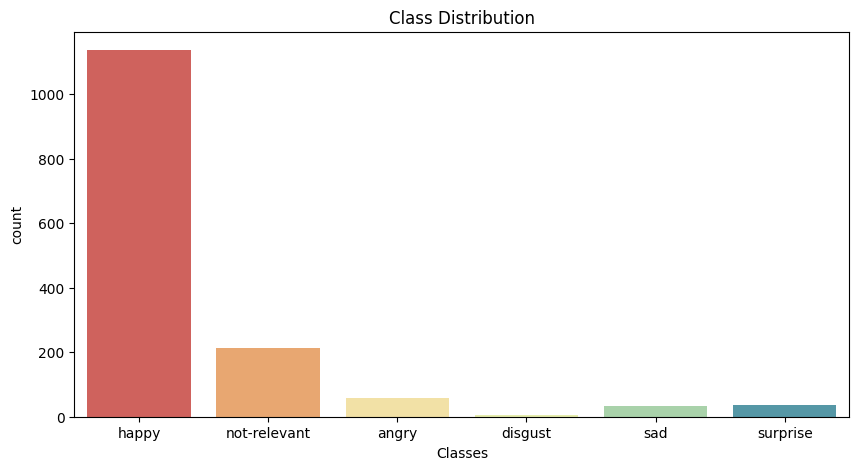

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=df.category, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [ ]:
possible_labels = df.category.unique()
possible_labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [ ]:
df['label'] = df.category.replace(label_dict)
df.head(10)

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy,0
613601881441570816,Yr 9 art students are off to the @britishmuseu...,happy,0
613696526297210880,@RAMMuseum Please vote for us as @sainsbury #s...,not-relevant,1
610746718641102848,#AskTheGallery Have you got plans to privatise...,not-relevant,1


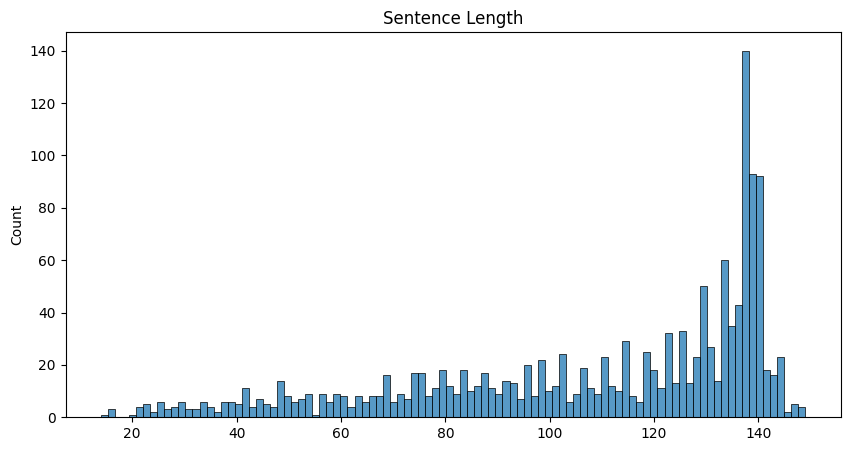

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  149


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [ ]:
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

In [ ]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.6 MB/s eta 0:00:00


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

{'input_ids': tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 27034,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        ...,
        [  101, 11047,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Encoding

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [ ]:
input_ids_train

tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 27034,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        ...,
        [  101, 11047,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]])

In [ ]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
labels_train

tensor([0, 0, 0,  ..., 0, 0, 1])

In [ ]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

1258
223


In [ ]:
dataset_train

In [ ]:
dataset_train.tensors

(tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
         [  101,  1030, 27034,  ...,     0,     0,     0],
         [  101,  1030, 10682,  ...,     0,     0,     0],
         ...,
         [  101, 11047,  1030,  ...,     0,     0,     0],
         [  101,  1030,  3680,  ...,     0,     0,     0],
         [  101,  1030,  2120,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 0, 0, 1]))

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 

dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

optimizer = torch.optim.AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
 
        batch = tuple(b.to(device) for b in batch)
 
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        with torch.no_grad():        
            outputs = model(**inputs)
 
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

## Train Model

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
for epoch in tqdm(range(1, epochs+1)):


    model.train()


    loss_train_total = 0
    

    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
 
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.7320920468322815


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6206600453172412
F1 Score (weighted): 0.781186302486751


Epoch 2:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4832551286230603


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6387766833816256
F1 Score (weighted): 0.8307288314043517


Epoch 3:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.32640033808817703


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6487720225538526
F1 Score (weighted): 0.8450920030033031


Epoch 4:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.20853457532800912


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6393314898014069
F1 Score (weighted): 0.8500691408193548


Epoch 5:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.14951962359537857


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.6814882755279541
F1 Score (weighted): 0.8390955427626422


Epoch 6:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.08185718415511979


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.7453878479344505
F1 Score (weighted): 0.8586969493701735


Epoch 7:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.047149261262910885


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.8037279716559819
F1 Score (weighted): 0.8553806455396088


Epoch 8:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.032459320750046844


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.8037513622215816
F1 Score (weighted): 0.8660423313537063


Epoch 9:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.0273419028792959


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.791987691606794
F1 Score (weighted): 0.8609037584250452


Epoch 10:   0%|          | 0/315 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.01830946399843217


  0%|          | 0/7 [00:00<?, ?it/s]

Validation loss: 0.8042707996709006
F1 Score (weighted): 0.8605009415099101


## Model Evaluation


In [ ]:
outputs.loss

tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
outputs.logits

tensor([[ 7.8009, -1.8664, -2.1645, -1.5888, -1.3183, -1.3807],
        [ 7.9168, -1.9190, -2.1041, -1.4858, -1.4857, -1.2502]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model.to(device)
pass

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy:163/171

Class: not-relevant
Accuracy:20/32

Class: angry
Accuracy:7/9

Class: disgust
Accuracy:0/1

Class: sad
Accuracy:1/5

Class: surprise
Accuracy:2/5

